In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import os

warnings.filterwarnings("ignore")


Notas sobre la implementación:
* El modelo ARIMA, al ser univariante, se ha aplicado únicamente a la serie del PIB. Se he utilizado la serie original, al estar en trimestres, y se ha realizado la comprobación del test AD para convertirla en estacionaria.
* El modelo VAR requiere todas las series transformadas, en una misma frecuencia y sin valores faltantes, condiciones que se han cumplido mediante la homogeneización y sincronización temporal. 
* Para el modelo SNARIMAX, se ha utilizado el PIB mensual como variable dependiente y se han incorporado variables exógenas (como el índice de confianza del consumidor), asegurando la alineación temporal y la estacionariedad de las series implicadas.

### ARIMA

In [2]:
# Cargar los datos transformados
df_arima = pd.read_csv("Indicadores_Muestra.csv", index_col="Fecha", parse_dates=True)

pib = df_arima["PIB"].dropna()


In [ ]:
def test_adf(df):
    """
    Aplica transformaciones automáticas (log si > 0, y una diferencia si no es estacionaria).
    
    Parámetros:
    -----------
    df: pd.DataFrame
        DataFrame con la serie temporal a transformar.

    Retorna:
    -----------
    - df_transformed: pd.DataFrame
        DataFrame con las series transformadas
    
    - df_resultados_adf: pd.DataFrame
        Resumen con log aplicado, diferencia, y p-valor ADF
    """
    df_transformed = pd.DataFrame(index=df.index)
    resultados_adf = []

    serie = df.dropna()
    log_aplicado = False
    diferencia_aplicada = False

    # Aplicar log si todos los valores son positivos
    if (serie > 0).all():
        serie = np.log(serie)
        log_aplicado = True
    
    # Test de ADF
    p_valor_og = adfuller(serie.dropna())[1]

    if p_valor_og > 0.05:
        
        # No estacionaria, aplicar una diferencia
        serie = serie.diff().dropna()
        diferencia_aplicada = True
        p_valor = adfuller(serie)[1]

    # Guardar transformación y resultado
    resultados_adf.append({
        "Log aplicado": log_aplicado,
        "Diferencia aplicada": diferencia_aplicada,
        "p-valor inicial ADF": p_valor_og,
        "p-valor final ADF": round(p_valor, 4)
    })

    # Guardar serie transformada
    df_transformed = serie

    df_resultados_adf = pd.DataFrame(resultados_adf)
    
    return df_transformed, df_resultados_adf

In [4]:
pib.head()

Fecha
1995-01-01    67.0160
1995-04-01    67.4578
1995-07-01    67.7565
1995-10-01    68.2696
1996-01-01    68.6618
Name: PIB, dtype: float64

In [5]:
pib.tail()

Fecha
2024-01-01    118.6042
2024-04-01    119.5708
2024-07-01    120.4238
2024-10-01    121.2817
2025-01-01    121.9704
Name: PIB, dtype: float64

In [6]:
df_transformed, df_resultados_adf = test_adf(pib)

In [7]:
df_resultados_adf

,Log aplicado,Diferencia aplicada,p-valor inicial ADF,p-valor final ADF
0,True,True,0.399281,0.0


In [8]:
# Separar en entrenamiento y prueba (80/20) # Al ser series temporales, se realiza una división secuencial en el tiempo.
split_index = int(len(df_transformed) * 0.8)
train, test = df_transformed[:split_index], df_transformed[split_index:]

In [9]:
# Predicción con modelo base

model_base = ARIMA(train, order=(1, 0, 1))
model_base_fit = model_base.fit()
print("\nResumen del modelo ARIMA(1,0,1):")
print(model_base_fit.summary())

# Predicción con el modelo base
forecast_base = model_base_fit.forecast(steps=len(test))

# Evaluación del modelo base
mae_base = mean_absolute_error(test, forecast_base)
mse_base = mean_squared_error(test, forecast_base)

print(f"\nEvaluación modelo ARIMA(1,0,1):")
print(f"MAE: {mae_base:.6f}")
print(f"MSE: {mse_base:.6f}")


Resumen del modelo ARIMA(1,0,1):
                               SARIMAX Results                                
Dep. Variable:                    PIB   No. Observations:                   96
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 395.171
Date:                Sun, 25 May 2025   AIC                           -782.341
Time:                        21:16:42   BIC                           -772.084
Sample:                    04-01-1995   HQIC                          -778.195
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.004      1.497      0.134      -0.002       0.012
ar.L1          0.8441      0.083     10.220      0.000       0.682       1.006
ma.L1         -0.1

In [10]:
# Modelo optimizado con auto_arima
stepwise_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print("\nMejor modelo ARIMA encontrado por auto_arima:")
print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-768.056, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-766.923, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-767.993, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-769.595, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-768.923, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-768.662, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-771.316, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-770.030, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-769.724, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-767.988, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-773.316, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-771.595, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-772.030, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-771.725, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]          

In [11]:
# Entrenar modelo óptimo en todos los datos
model_opt = ARIMA(train, order=stepwise_model.order)
model_opt_fit = model_opt.fit()

# Predicción del modelo
forecast_opt = model_opt_fit.forecast(steps=len(test))

# Evaluación
mae_final = mean_absolute_error(test, forecast_opt)
mse_final = mean_squared_error(test, forecast_opt)

print(f"\nEvaluación modelo ARIMA óptimo {stepwise_model.order}:")
print(f"MAE: {mae_final:.6f}")
print(f"MSE: {mse_final:.6f}")


Evaluación modelo ARIMA óptimo (0, 1, 2):
MAE: 0.020376
MSE: 0.002710


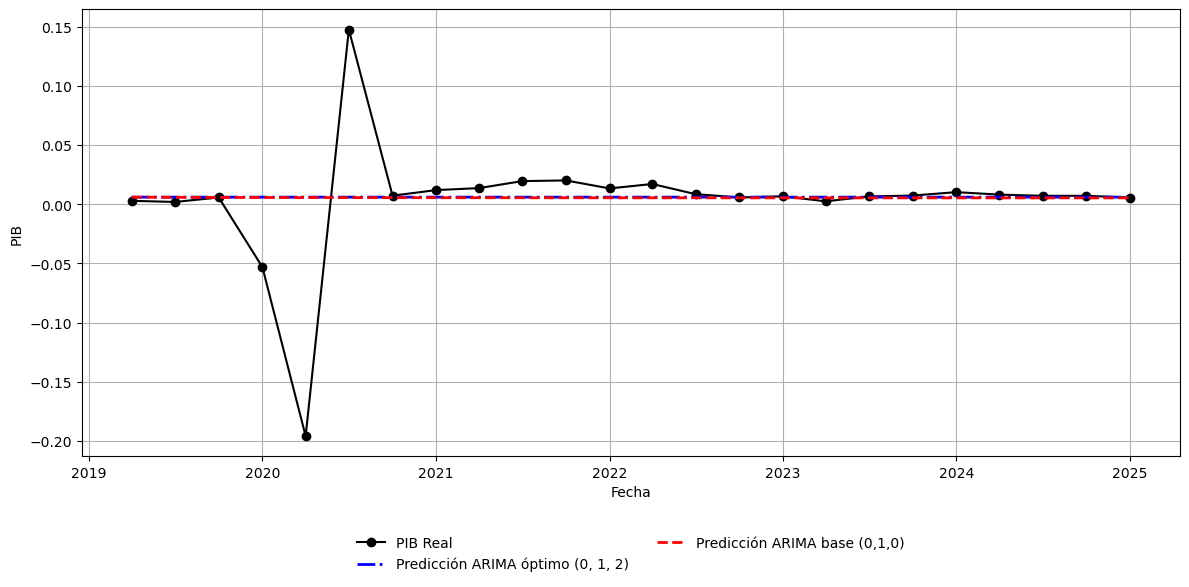

In [12]:
# Gráfico de comparación entre modelos ARIMA y PIB real
output_dir="Implementación_output"

os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, marker='o', linestyle='-', color='black', label="PIB Real")
plt.plot(test.index, forecast_opt, linestyle='-.', color='blue', linewidth=2, label=f"Predicción ARIMA óptimo {stepwise_model.order}")
plt.plot(test.index, forecast_base, linestyle='--', color='red', linewidth=2, label=f"Predicción ARIMA base (0,1,0)")
plt.xlabel("Fecha")
plt.ylabel("PIB")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "ARIMA_gráfico.png"))
plt.show()
plt.close()

In [ ]:
def analizar_residuos(residuals, titulo="Residuos del Modelo"):
    """
    Analiza visual y estadísticamente la serie de residuos de un modelo temporal.

    Parámetros:
    -----------
    residuals : pd.Series
        Serie de residuos obtenidos de un modelo de series temporales.

    titulo : str, opcional (por defecto "Residuos del Modelo")
        Título descriptivo que se mostrará en los gráficos y en la salida del test.
    """

    # Aplicación del test de Ljung-Box (lags=10) para verificar si los residuos son ruido blanco. Hipótesis nula: no hay autocorrelación significativa en los residuos.
    test_ljungbox = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print(f"\nTest de Ljung-Box para residuos ({titulo}):")

    # Hipótesis nula: los residuos no están autocorrelacionados (es decir, no son ruido blanco)
    print(test_ljungbox)

    # Gráfico de los residuos
    plt.figure(figsize=(12, 4))
    plt.plot(residuals, label="Residuos", color='purple')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(titulo)
    plt.xlabel("Fecha")
    plt.ylabel("Valor del Residuo")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Histograma de residuos
    plt.figure(figsize=(8, 4))
    plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Distribución de los {titulo}")
    plt.xlabel("Valor del Residuo")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Test de Ljung-Box para residuos (Residuos del Modelo ARIMA base (1,0,1)):
     lb_stat  lb_pvalue
10  3.880683   0.952569


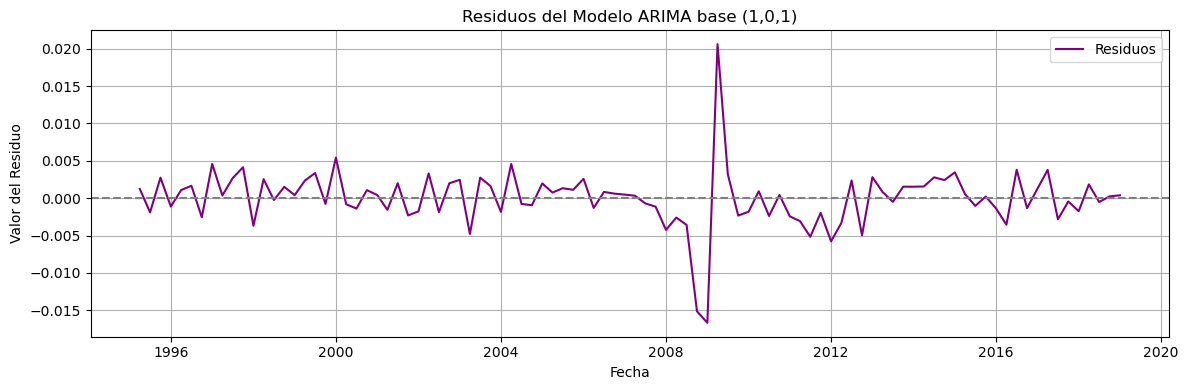

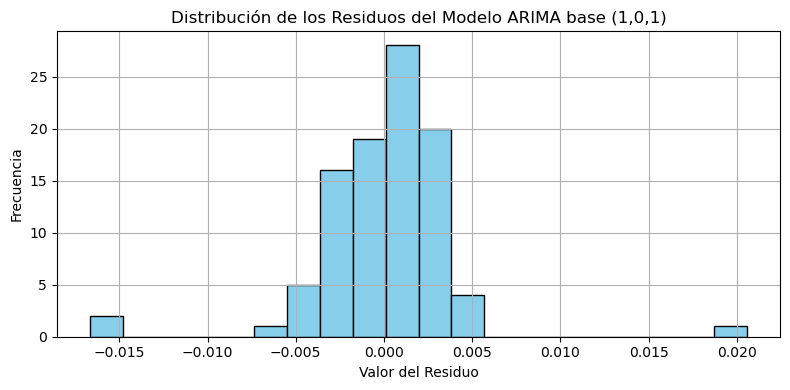


Test de Ljung-Box para residuos (Residuos del Modelo ARIMA óptimo (0, 1, 2)):
    lb_stat  lb_pvalue
10  3.11816   0.978505


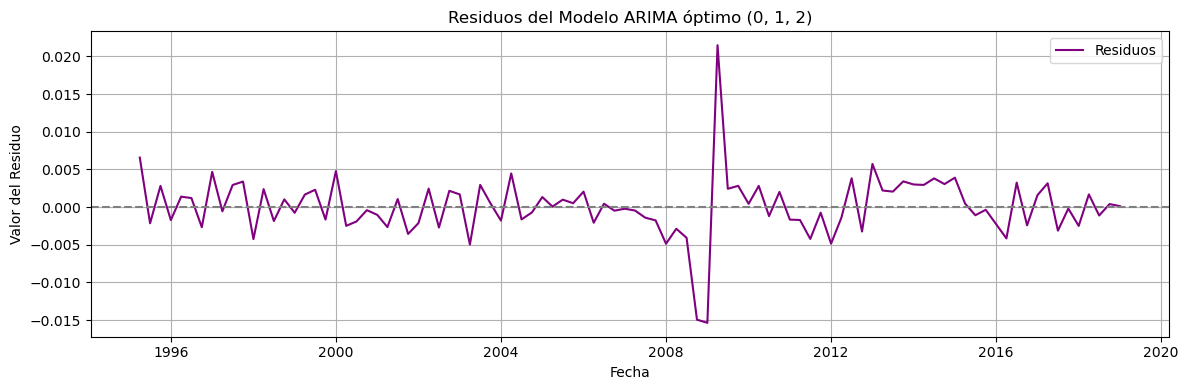

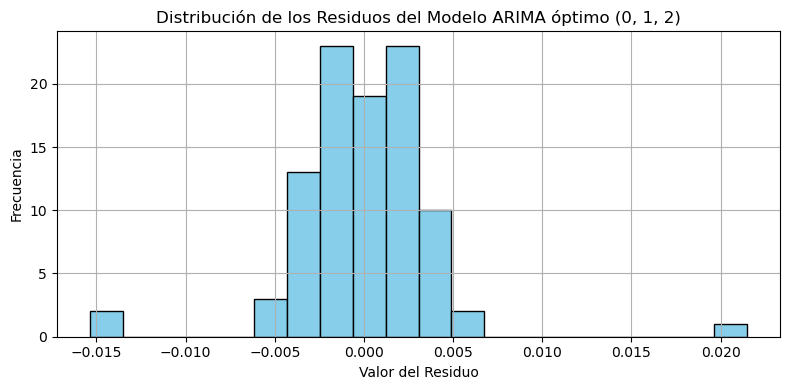

In [14]:
# Análisis de residuos de ambos modelos
analizar_residuos(model_base_fit.resid, "Residuos del Modelo ARIMA base (1,0,1)")
analizar_residuos(model_opt_fit.resid, f"Residuos del Modelo ARIMA óptimo {stepwise_model.order}")


### VAR

In [15]:
# Cargar los datos para VAR

df_var = pd.read_csv("df_var.csv", index_col="Fecha", parse_dates=True)

In [16]:
df_var = df_var.dropna()

In [17]:
# Separar en entrenamiento y prueba (80/20)
split_index = int(len(df_var) * 0.8)
train, test = df_var[:split_index], df_var[split_index:]

In [18]:
# Ajustar modelo VAR en entrenamiento
model = VAR(train)
lag_order = model.select_order(5)
selected_lag = lag_order.aic
print("\nOrden de rezago seleccionado (AIC):", selected_lag)


Orden de rezago seleccionado (AIC): 5


In [19]:
model_fitted = model.fit(selected_lag)
print(model_fitted.summary())

# Predicción
forecast = model_fitted.forecast(train.values, steps=len(test))
forecast_df = pd.DataFrame(forecast, index=test.index, columns=df_var.columns)

# Evaluación solo para PIB
mae_var = mean_absolute_error(test["PIB"], forecast_df["PIB"])
mse_var = mean_squared_error(test["PIB"], forecast_df["PIB"])

print(f"\nEvaluación del modelo VAR sobre PIB:")
print(f"MAE: {mae_var:.6f}")
print(f"MSE: {mse_var:.6f}")

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 25, May, 2025
Time:                     21:16:45
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -77.9250
Nobs:                     128.000    HQIC:                  -83.4016
Log likelihood:           4356.95    FPE:                1.91736e-38
AIC:                     -87.1496    Det(Omega_mle):     1.20962e-39
--------------------------------------------------------------------
Results for equation EPA
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.105694         0.073052           -1.447           0.148
L1.EPA          1.011307         0.259544            3.896           0.000
L1.PIB         -0.129864         0.105744           -1.228           0.219
L1.AFI     

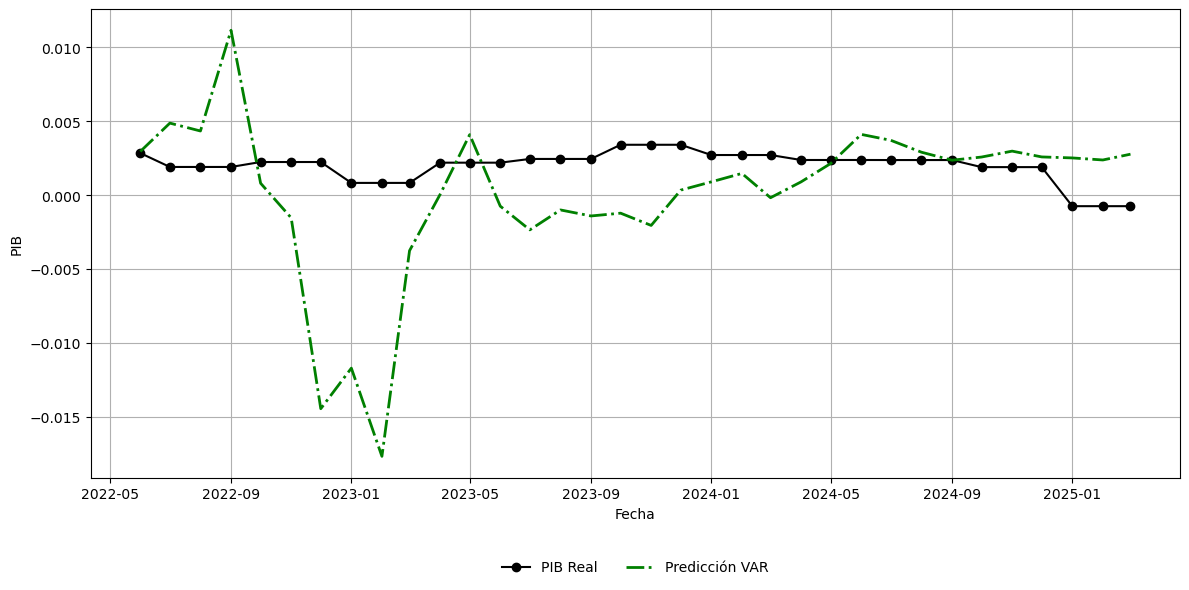

In [20]:
# Gráfico de comparación
plt.figure(figsize=(12, 6))
plt.plot(test.index, test["PIB"], marker='o', linestyle='-', color='black', label="PIB Real")
plt.plot(test.index, forecast_df["PIB"], linestyle='-.', color='green', linewidth=2, label="Predicción VAR")
plt.xlabel("Fecha")
plt.ylabel("PIB")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "VAR_gráfico.png"))
plt.show()
plt.close()



In [ ]:
def analizar_residuos_var(residuals_df):
    """
    Analiza los residuos de un modelo VAR (Vector AutoRegresivo) para cada variable incluida en el modelo.

    Parámetros:
    -----------
    residuals_df : pd.DataFrame
        DataFrame con los residuos del modelo VAR. Cada columna representa los residuos de una variable del sistema.
    """

    for col in residuals_df.columns:
        print(f"\nResiduos para variable: {col}")

        # Aplica el test de Ljung-Box (lags=10)
        result = acorr_ljungbox(residuals_df[col], lags=[10], return_df=True)
        print(result)

        # Gráfico de residuos
        plt.figure(figsize=(12, 4))
        plt.plot(residuals_df.index, residuals_df[col], label="Residuos", color='purple')
        plt.axhline(0, color='gray', linestyle='--')
        plt.title(f"Residuos del modelo VAR - {col}")
        plt.xlabel("Fecha")
        plt.ylabel("Valor del Residuo")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Histograma de residuos
        plt.figure(figsize=(8, 4))
        plt.hist(residuals_df[col], bins=20, color='skyblue', edgecolor='black')
        plt.title(f"Distribución de los residuos - {col}")
        plt.xlabel("Valor del Residuo")
        plt.ylabel("Frecuencia")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Residuos para variable: EPA
     lb_stat  lb_pvalue
10  8.481156   0.581946


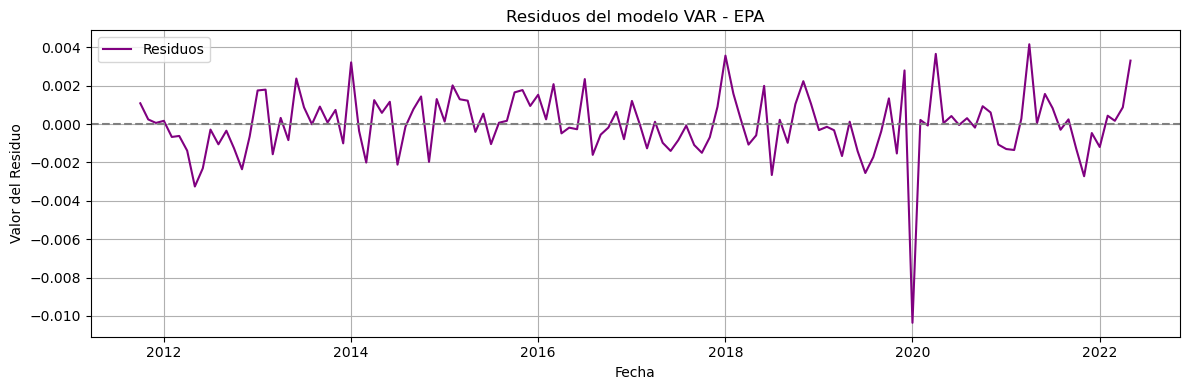

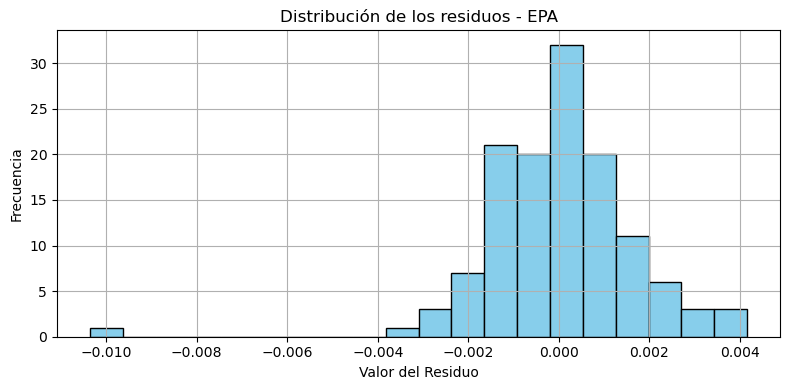


Residuos para variable: PIB
     lb_stat  lb_pvalue
10  9.707518   0.466518


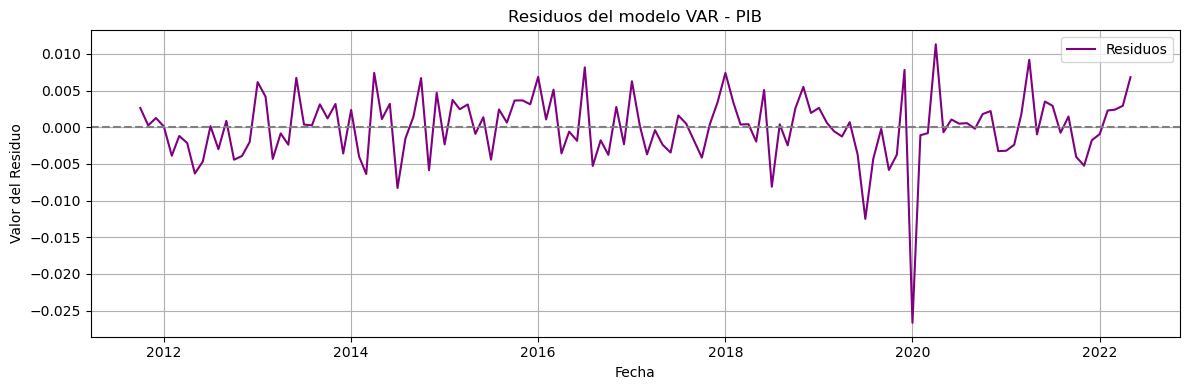

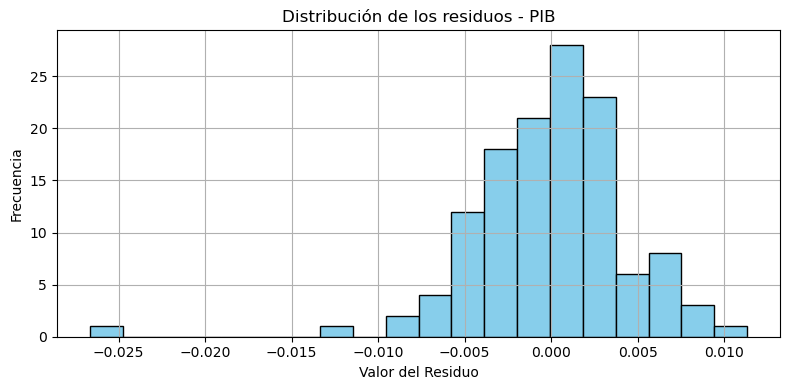


Residuos para variable: AFI
      lb_stat  lb_pvalue
10  14.156298   0.165981


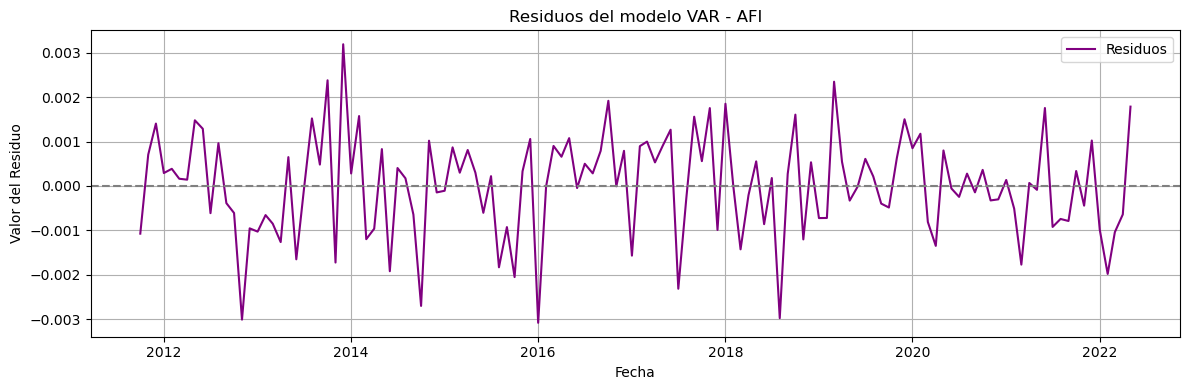

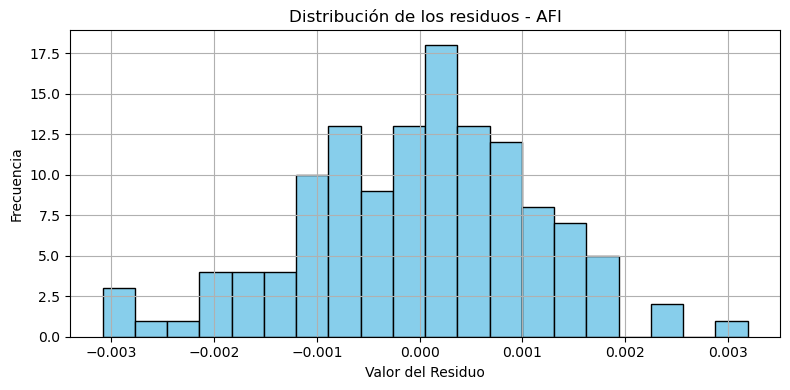


Residuos para variable: PMI
      lb_stat  lb_pvalue
10  10.160136   0.426558


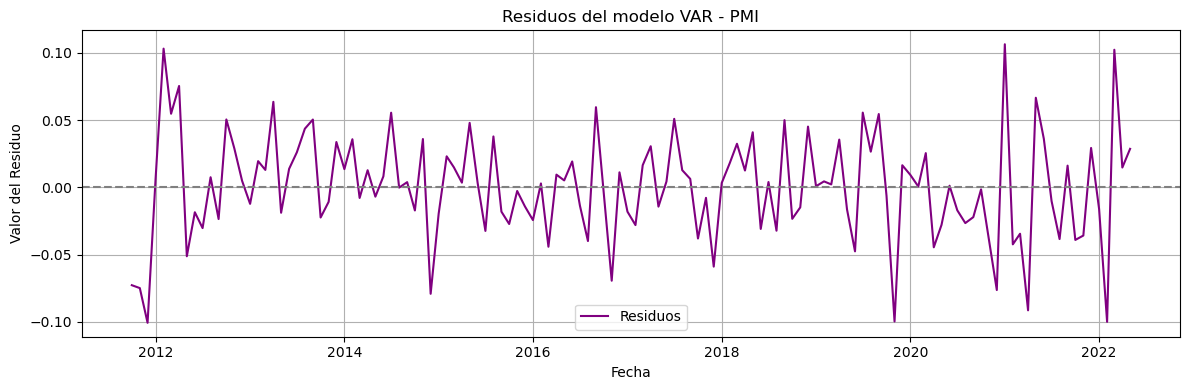

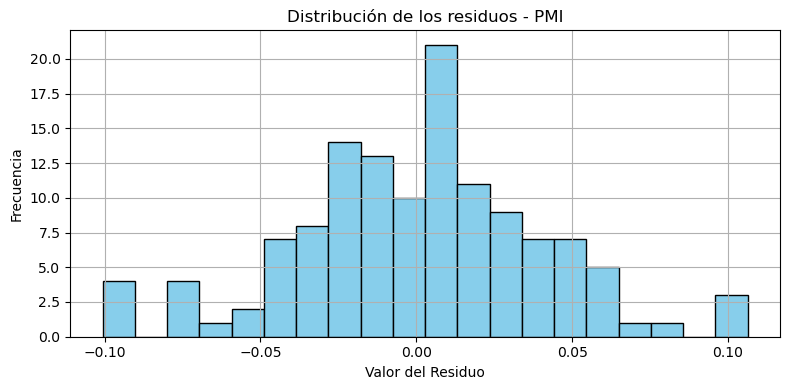


Residuos para variable: VGE
     lb_stat  lb_pvalue
10  7.277082   0.699053


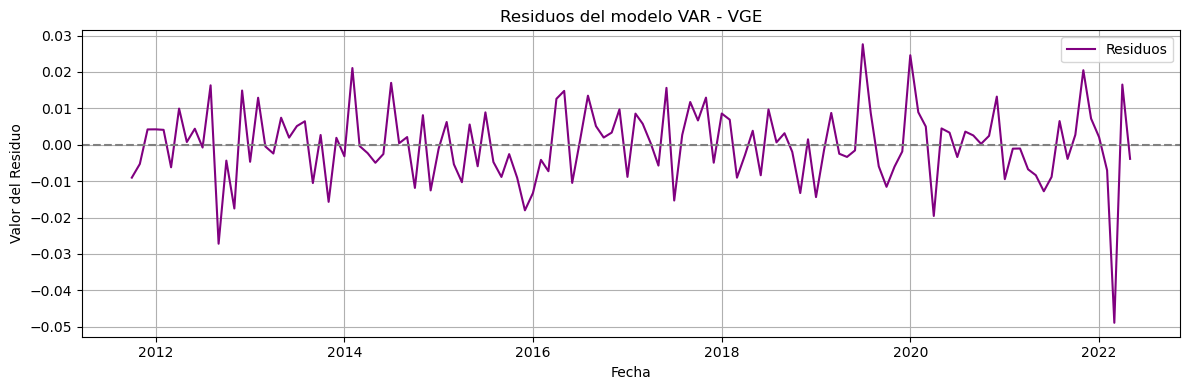

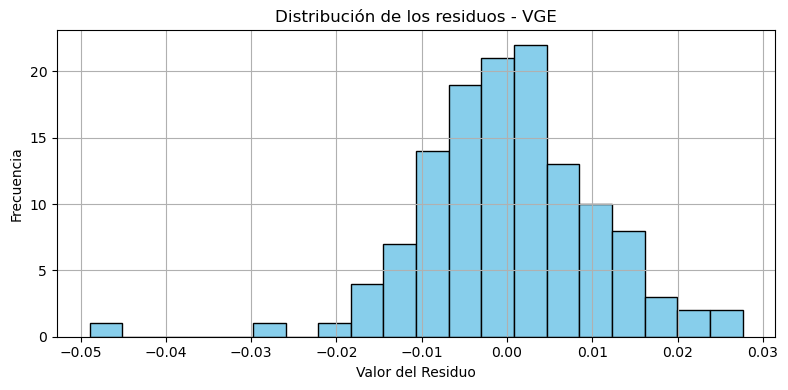


Residuos para variable: RBT
     lb_stat  lb_pvalue
10  6.050501   0.811003


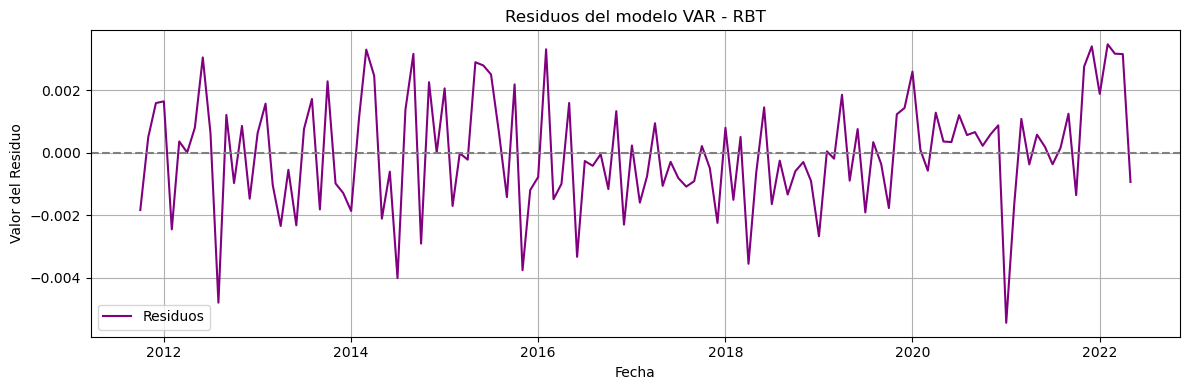

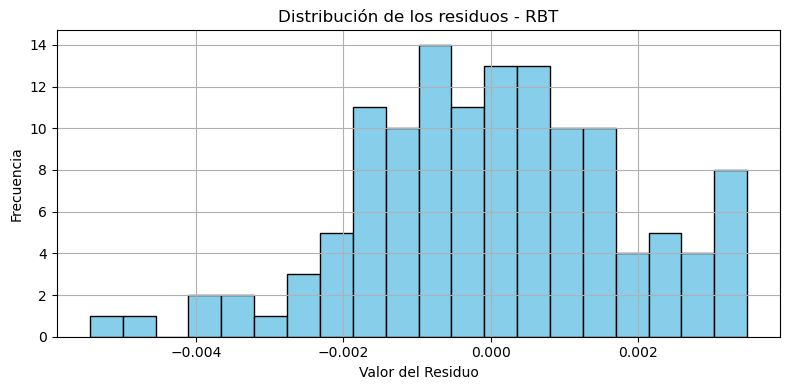


Residuos para variable: IASS
     lb_stat  lb_pvalue
10  3.259926   0.974629


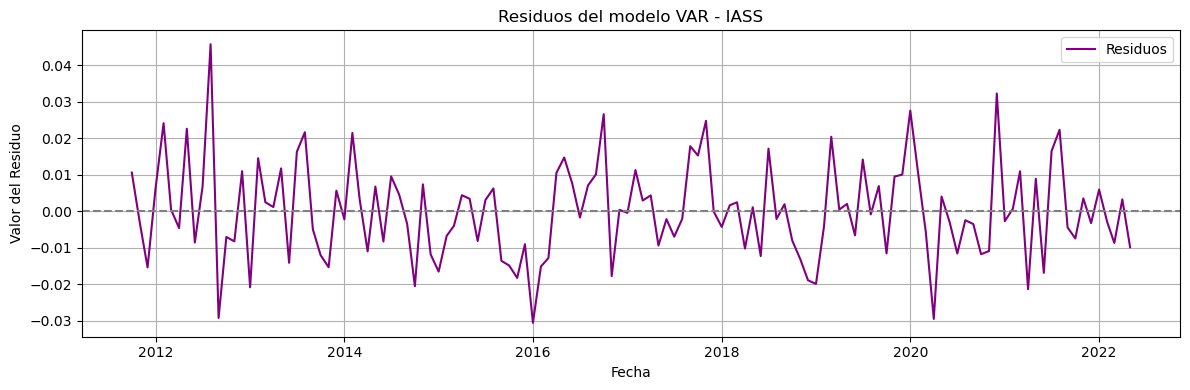

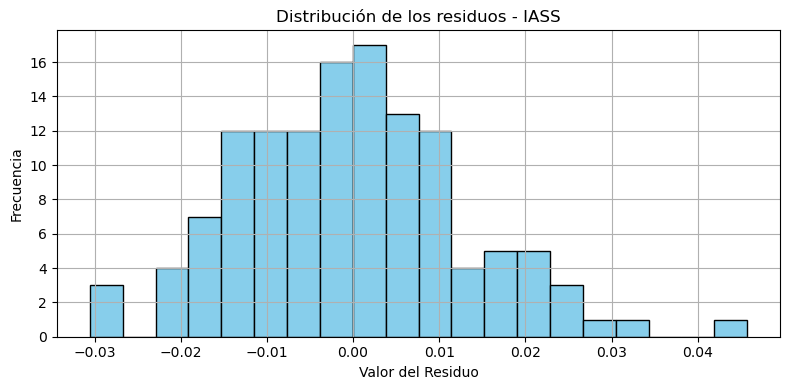


Residuos para variable: IPI
     lb_stat  lb_pvalue
10  3.348084   0.972007


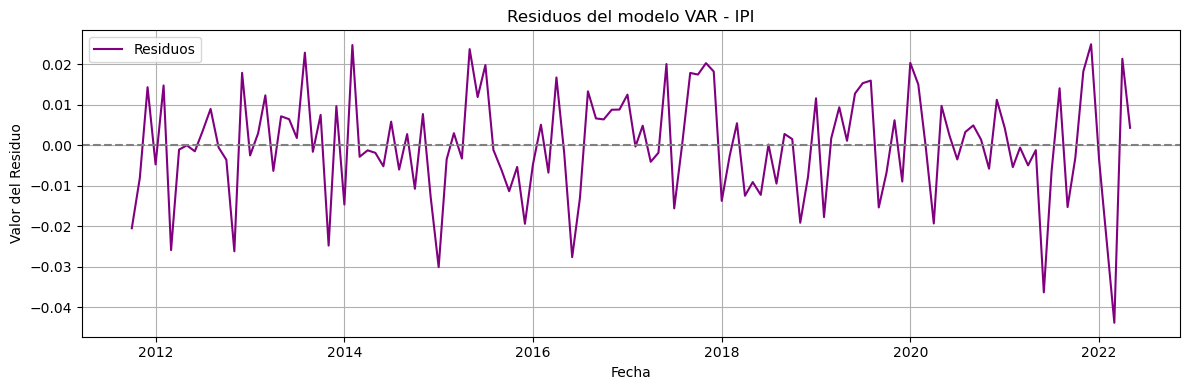

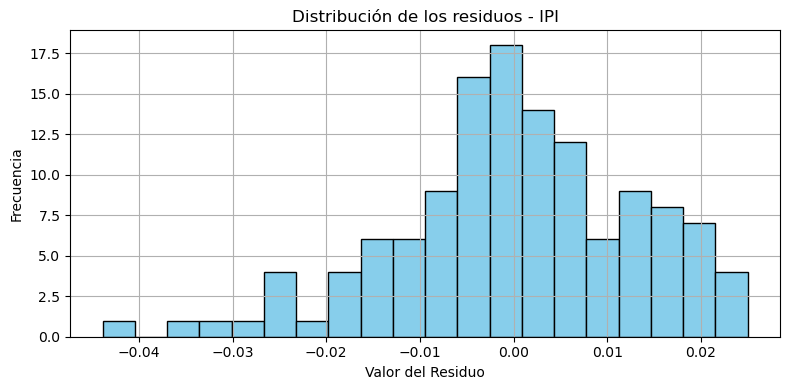


Residuos para variable: IMPB
      lb_stat  lb_pvalue
10  11.971694   0.286955


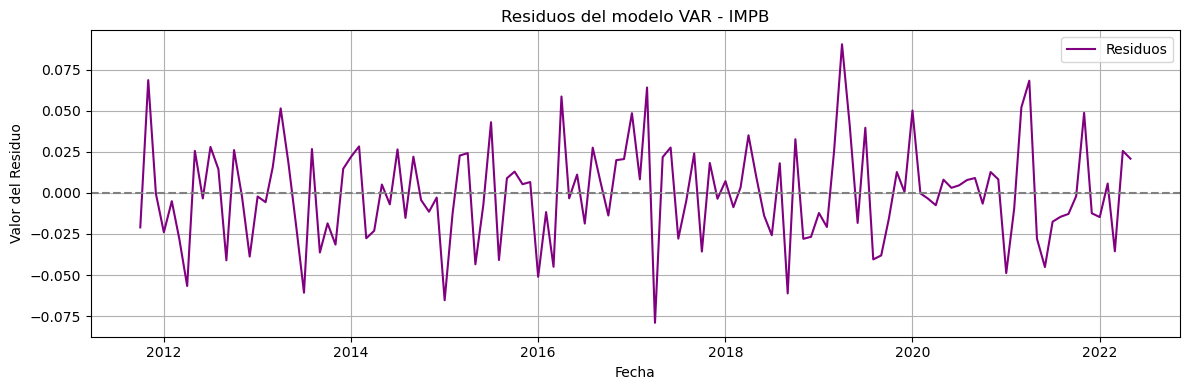

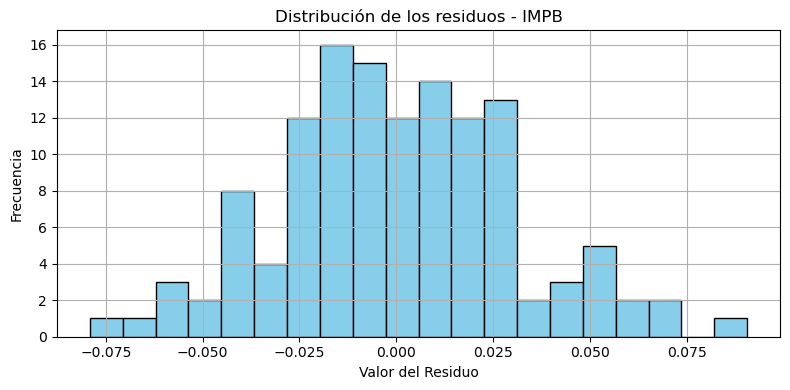

In [22]:
# Análisis de residuos
analizar_residuos_var(model_fitted.resid)

### SNARIMAX

**Variable exógena seleccionada:** Confianza del Consumidor



In [23]:
 # Cargar los datos transformados con la variable exógena
df = pd.read_csv("df_snarimax.csv", index_col="Fecha", parse_dates=True)

# Selección de variable dependiente y exógena
endog = df["PIB"].dropna()
exog = df[["CCI"]].dropna()

In [24]:
# Alineación por fechas comunes
common_index = endog.index.intersection(exog.index)
endog = endog.loc[common_index]
exog = exog.loc[common_index]

In [25]:
# División train/test
split_idx = int(len(endog) * 0.8)
train_endog, test_endog = endog[:split_idx], endog[split_idx:]
train_exog, test_exog = exog[:split_idx], exog[split_idx:]

In [26]:
# Modelo SARIMAX simple (parsimonioso)
model_simple = SARIMAX(train_endog, exog=train_exog, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
model_simple_fit = model_simple.fit(disp=False)

# Predicción:
forecast_simple = model_simple_fit.predict(start=len(train_endog), end=len(endog)-1, exog=test_exog)

# Evaluación:
mae_simple = mean_absolute_error(test_endog, forecast_simple)
mse_simple = mean_squared_error(test_endog, forecast_simple)

print("\nEvaluación modelo SARIMAX simple (1,0,1)(1,0,1)[12]:")
print(f"MAE: {mae_simple:.6f}")
print(f"MSE: {mse_simple:.6f}")


Evaluación modelo SARIMAX simple (1,0,1)(1,0,1)[12]:
MAE: 0.007914
MSE: 0.000299


In [27]:
# Búsqueda automática de parámetros con auto_arima
model_auto = auto_arima(train_endog, exogenous=train_exog, seasonal=True, m=12, trace=False, error_action='ignore', suppress_warnings=True)

order = model_auto.order
seasonal_order = model_auto.seasonal_order
print(f"\nParámetros óptimos encontrados: order={order}, seasonal_order={seasonal_order}")

# Modelo SARIMAX óptimo
model_opt = SARIMAX(train_endog, exog=train_exog, order=order, seasonal_order=seasonal_order)
model_opt_fit = model_opt.fit(disp=False)

# Predicción
forecast_opt = model_opt_fit.predict(start=len(train_endog), end=len(endog)-1, exog=test_exog)

# Evaluación
mae_opt = mean_absolute_error(test_endog, forecast_opt)
mse_opt = mean_squared_error(test_endog, forecast_opt)

print("\nEvaluación modelo SARIMAX óptimo:")
print(f"MAE: {mae_opt:.6f}")
print(f"MSE: {mse_opt:.6f}")


Parámetros óptimos encontrados: order=(0, 1, 0), seasonal_order=(0, 0, 0, 12)

Evaluación modelo SARIMAX óptimo:
MAE: 0.007339
MSE: 0.000297


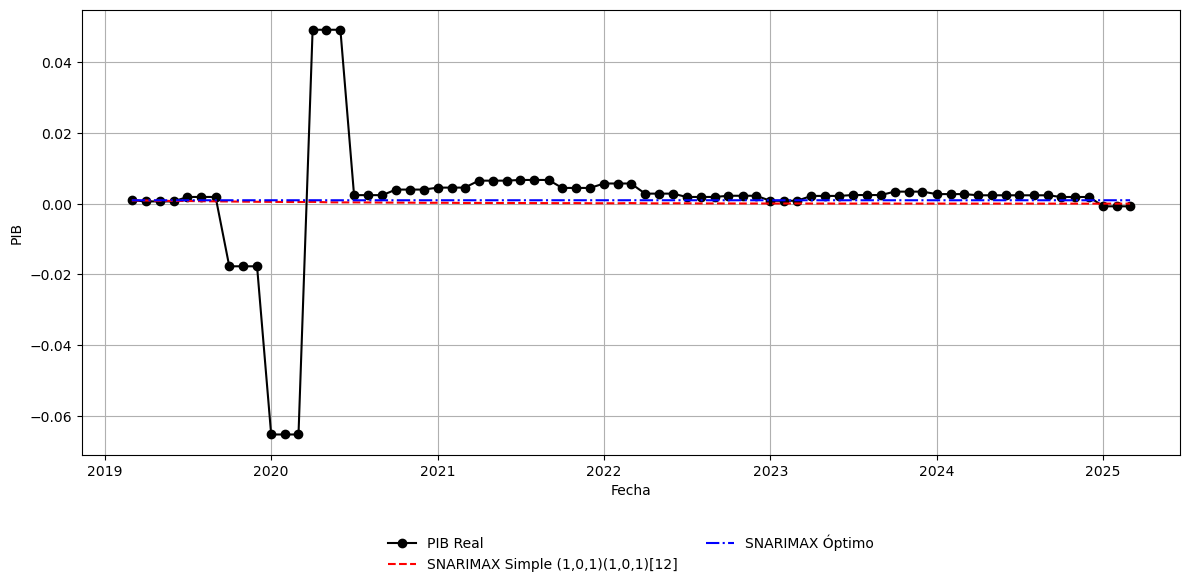

In [28]:
# Gráfico comparativo
plt.figure(figsize=(12, 6))
plt.plot(test_endog.index, test_endog, marker='o', label="PIB Real", color='black')
plt.plot(test_endog.index, forecast_simple, linestyle='--', color='red', label="SNARIMAX Simple (1,0,1)(1,0,1)[12]")
plt.plot(test_endog.index, forecast_opt, linestyle='-.', color='blue', label="SNARIMAX Óptimo")
plt.xlabel("Fecha")
plt.ylabel("PIB")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "SNARIMAX_gráfico.png"))
plt.show()
plt.close()

In [29]:
# print(endog.index.min(), endog.index.max())
# print(test_endog.index.min(), test_endog.index.max())
# print(test.index.min(), test.index.max())

### Análisis de Concept-Drift

In [30]:
# Separación clara de períodos
cutoff = '2020-01-01'
pre_data = df_var.loc[:'2019-12-31']
post_data = df_var.loc[cutoff:]

In [31]:
# Ventanas de prueba
n_test = 5
train_pre = pre_data.iloc[:-n_test]
test_pre = pre_data.iloc[-n_test:]

train_post = post_data.iloc[:-n_test]
test_post = post_data.iloc[-n_test:]

In [32]:
train_pre = pre_data.iloc[:-n_test]
test_pre = pre_data.iloc[-n_test:]

train_post = post_data.iloc[:-n_test]
test_post = post_data.iloc[-n_test:]

In [33]:
# Entrenamiento VAR
model_pre = VAR(train_pre).fit(maxlags=1, ic='aic')
model_post = VAR(train_post).fit(maxlags=1, ic='aic')

In [34]:
# Forecast desde el final del training
forecast_pre = model_pre.forecast(train_pre.values[-model_pre.k_ar:], steps=n_test)
forecast_post = model_post.forecast(train_post.values[-model_post.k_ar:], steps=n_test)


In [35]:
# Evaluación para PIB
true_pre = test_pre["PIB"].values
true_post = test_post["PIB"].values

pred_pre = forecast_pre[:, train_pre.columns.get_loc("PIB")]
pred_post = forecast_post[:, train_post.columns.get_loc("PIB")]


In [36]:
model_pre.params

,EPA,PIB,AFI,PMI,VGE,RBT,IASS,IPI,IMPB
const,-0.025567,0.007251,-0.047323,1.579885,0.000915,-0.078703,-0.330590,0.558122,3.078803
L1.EPA,0.678037,0.104107,0.138520,3.763225,1.624837,-0.132596,0.227443,3.067781,3.447713
L1.PIB,0.333002,0.880987,0.237495,7.089086,2.702118,0.232354,3.215219,-1.294870,-6.382952
L1.AFI,0.014737,-0.028769,0.441768,8.176725,-0.658719,-0.169866,-0.033028,0.865595,1.946611
L1.PMI,-0.000766,0.000650,0.003969,0.564061,-0.027653,0.003275,-0.029293,-0.013313,0.153781
L1.VGE,-0.011308,-0.004864,0.006431,0.833369,-0.377281,-0.002812,-0.074212,-0.014143,-0.537300
L1.RBT,-0.061753,-0.040736,-0.033863,-0.521158,0.118542,-0.374923,0.277978,0.366663,4.062208
L1.IASS,-0.004678,-0.008381,-0.004193,0.026962,-0.204141,-0.004411,-0.509648,-0.055073,-0.060775
L1.IPI,0.002558,-0.000066,-0.009771,-0.410126,0.007832,-0.004087,0.009275,-0.365499,-0.175629
L1.IMPB,0.001682,-0.000570,0.001880,0.007288,0.006288,0.003891,0.026270,-0.029900,0.782909


In [37]:
# Extraer los coeficientes de la ecuación del PIB
coef_pre = model_pre.params
coef_post = model_post.params

In [38]:
# Métricas
mse_pre = mean_squared_error(true_pre, pred_pre)
mae_pre = mean_absolute_error(true_pre, pred_pre)

mse_post = mean_squared_error(true_post, pred_post)
mae_post = mean_absolute_error(true_post, pred_post)

In [39]:
# Comparación de parámetros
drift_magnitude = np.linalg.norm(model_pre.params.values - model_post.params.values)

print("Magnitud del cambio en coeficientes (Frobenius):", drift_magnitude)
print("Errores VAR Pre-2020:", round(mse_pre, 8), round(mae_pre, 8))
print("Errores VAR Post-2020:", round(mse_post, 8), round(mae_post, 8))

Magnitud del cambio en coeficientes (Frobenius): 18.657841019656644
Errores VAR Pre-2020: 0.00023454 0.01190709
Errores VAR Post-2020: 2.386e-05 0.00472776


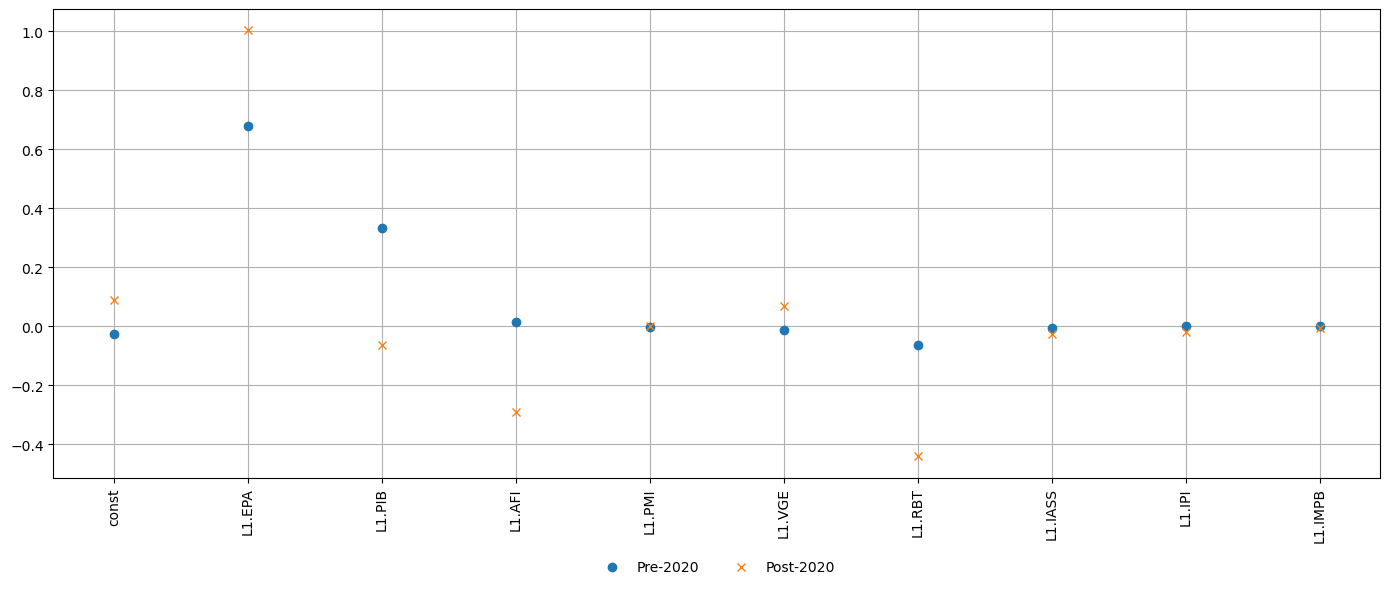

In [40]:
plt.figure(figsize=(14, 6))
plt.plot(coef_pre.index, coef_pre.iloc[:, 0], marker='o', label='Pre-2020', linestyle='none')
plt.plot(coef_post.index, coef_post.iloc[:, 0], marker='x', label='Post-2020', linestyle='none')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Comparacion_coeficientes.png"))
plt.show()
plt.close()